### Zaimportowanie odpowiednich bibliotek

In [144]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns 

import tensorflow_datasets

import keras
from keras.utils.np_utils import to_categorical

import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

In [145]:
sns.set_style('darkgrid')

In [146]:
import warnings
warnings.filterwarnings('ignore')

### Pobranie i wybór danych do dalszej analizy

##### (b)

Klasy Fashion MNIST:

* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

In [147]:
class_value_map = {
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

class_values = list(class_value_map.keys())

In [148]:
# wczytanie danych z wykorzystaniem TF/Keras API

fashion_mnist_data = keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist_data.load_data()

In [149]:
train_data_mask = np.isin(y_train, class_values)
test_data_mask = np.isin(y_test, class_values)

X_train, y_train = X_train[train_data_mask], y_train[train_data_mask]
X_test, y_test = X_test[test_data_mask], y_test[test_data_mask]

## Wersja I rozwiązania - zastosowanie modelu regresji logistycznej

### Eksploracja danych

#### Sprawdzenie zawartości danych

In [150]:
print("Wymiar zestawu treningowego:", X_train.shape)
print("Wymiar zestawu testowego:", X_test.shape)

Wymiar zestawu treningowego: (30000, 28, 28)
Wymiar zestawu testowego: (5000, 28, 28)


W zestawie danych treningowych znajduje się 30000 obrazów, natomiast w zestawie testowym 5000 obrazów. Każdy obraz jest wymiaru 28x28 pikseli.

In [151]:
print('Liczba etykiet dla zestawu treningowego:', len(y_train))
print('Liczba etykiet dla zestawu testowego:', len(y_test))

print('Wartości etykiet w zestawie treningowym:', list(set(y_train)))
print('Wartości etykiet w zestawie testowym:', list(set(y_test)))

Liczba etykiet dla zestawu treningowego: 30000
Liczba etykiet dla zestawu testowego: 5000
Wartości etykiet w zestawie treningowym: [5, 6, 7, 8, 9]
Wartości etykiet w zestawie testowym: [5, 6, 7, 8, 9]


Dla każdego obrazu istnieje odpowiednia etykieta. Etykiety są w postaci przypisanej cyfry.

#### Podgląd wybranych obrazów

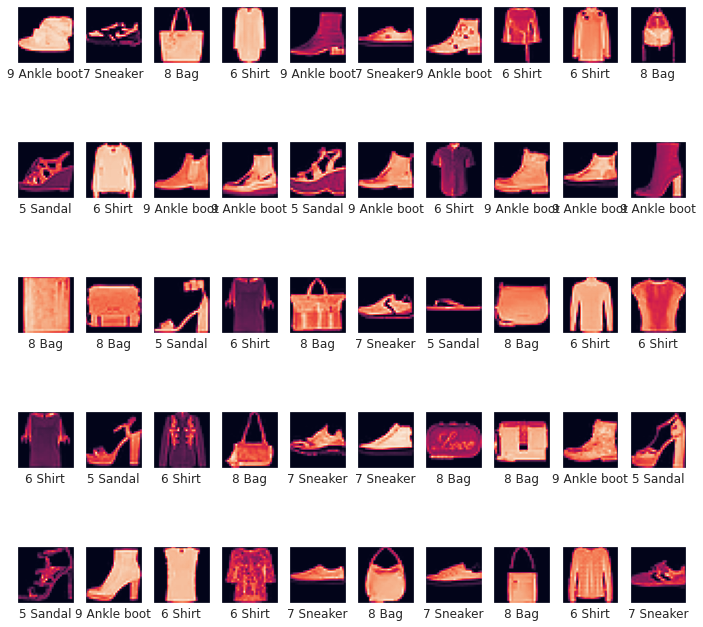

In [152]:
plt.figure(figsize=(12,12))
for i in range(50):
  plt.subplot(5, 10, i+1)
  idx = np.random.randint(0, len(y_train))
  plt.imshow(X_train[idx])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(str(y_train[idx]) + ' ' + class_value_map[y_train[idx]])

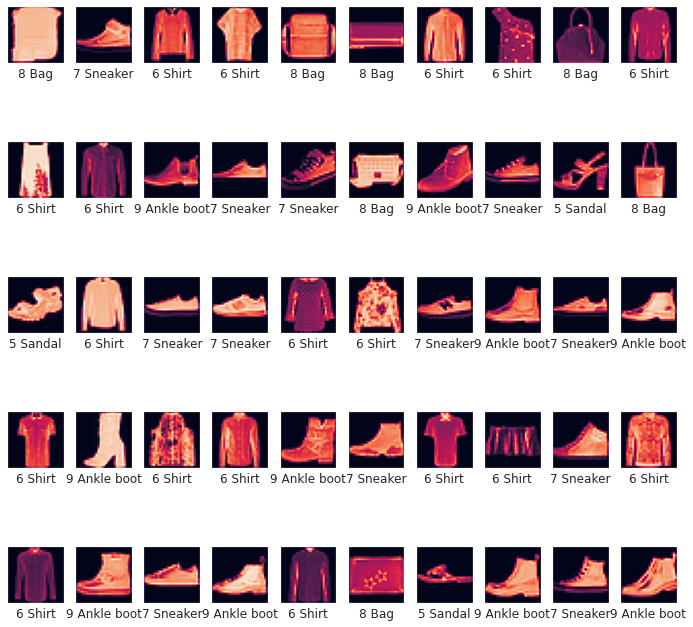

In [153]:
plt.figure(figsize=(12,12))
for i in range(50):
  plt.subplot(5, 10, i+1)
  idx = np.random.randint(0, len(y_test))
  plt.imshow(X_test[idx])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(str(y_test[idx]) + ' ' + class_value_map[y_test[idx]])

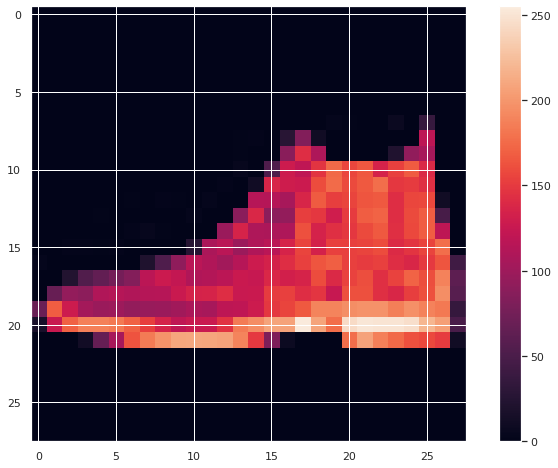

In [154]:
plt.figure()
plt.imshow(X_test[0])
plt.colorbar()
plt.show()

Zakres wartości poszczególnych pikseli obrazu zawiera się w zakresie od 0 do 255. Warto w przetwarzaniu wstępnym dokonać przeskalowania danych do zakresu wartości od 0 do 1, ponieważ większość modeli uczenia maszynowego jest czuła na zakres danych.

### Przetwarzanie wstępne


#### (c)

#### Normalizacja wartości pikseli

In [155]:
# ustawienie zakresu od 0 do 1
X_train = X_train / 255.0
X_test = X_test / 255.0

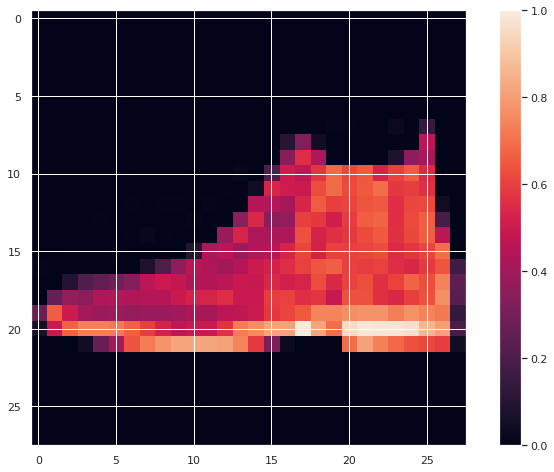

In [156]:
plt.figure()
plt.imshow(X_test[0])
plt.colorbar()
plt.show()

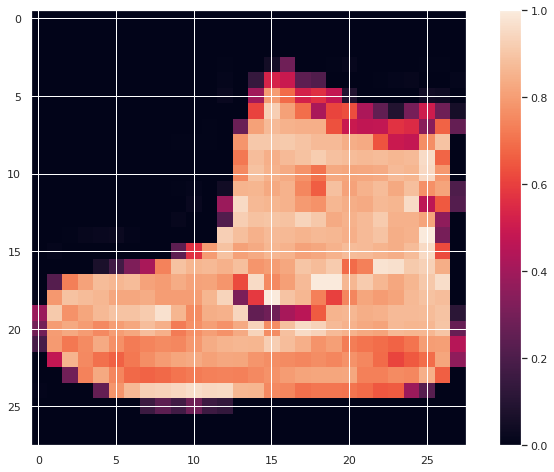

In [157]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.show()

Zakres wartości pikseli odpowiednio zmodyfikowano do zakresu [0, 1].

#### Ustalenie odpowiednich wymiarów

In [158]:
def apply_reshape(dataset):
  n_samples, n_x, n_y = dataset.shape
  reshaped_dataset = dataset.reshape((n_samples, n_x*n_y))
  print(f'Modyfikacja z {dataset.shape} do {reshaped_dataset.shape}')
  return reshaped_dataset

In [159]:
X_train = apply_reshape(X_train)

Modyfikacja z (30000, 28, 28) do (30000, 784)


In [160]:
X_test = apply_reshape(X_test)

Modyfikacja z (5000, 28, 28) do (5000, 784)


In [161]:
X = np.r_[X_train, X_test]
y = np.r_[y_train, y_test]

#### Redukcja wymiarów

Text(0, 0.5, 'Skumulowana wartość wariancji')

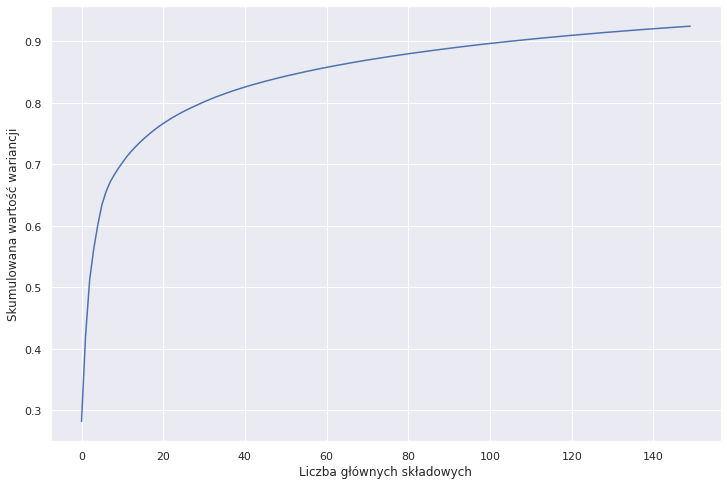

In [162]:
pca = PCA(n_components=150)
pca_data = pca.fit_transform(X)
pca_result = pd.DataFrame(data=pca_data)
variances = pca.explained_variance_ratio_

plt.figure(figsize=(12,8))
plt.plot(np.cumsum(variances))
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Skumulowana wartość wariancji')

In [163]:
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

In [164]:
X_reduced = pca.fit_transform(X)

In [165]:
print(X_train_reduced.shape)
print(X_test_reduced.shape)
print(X_reduced.shape)

(30000, 150)
(5000, 150)
(35000, 150)


### Klasyfikacja danych i walidacja modelu
#### (d), (e)

#### Funkcje i operacje pomocnicze

In [166]:
def print_metrics(f1_weighted_scores):
  print('---------------------------------------------------------------------------')
  print(f'Wyniki F1 weighted dla kolejnych modeli: {f1_weighted_scores}')
  print(f'Średnia wyników F1 weighted: {f1_weighted_scores.mean()}')
  print(f'Odchylenie standardowe wyników F1 weighted {f1_weighted_scores.std()}')
  print('---------------------------------------------------------------------------')

In [167]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

#### Regresja logistyczna

Hiperparametry:

* C=2 - odpowiada za siłę regularyzacji, mniejsze wartości oznaczają silniejszą regularyzację (wartość domyślna: C=1)
* solver='saga' - algorytm wykorzystywany w optymalizacji, dla problemu klasyfikacji wieloklasowej - należy wybrać m.in.: ‘newton-cg’, ‘sag’, ‘saga’, ‘lbfgs’
* penalty='l1' - hiperaparametr dostosowany do wybranego algorytmu dla hiperparametru 'solver'

In [ ]:
lr_clf = LogisticRegression(C=2,
                            random_state=97,
                            solver='saga',
                            penalty='l1',
                            multi_class='multinomial')

Trzy powtórzenia treningu i testowania modelu z wykorzystaniem walidacji krzyżowej

In [ ]:
lr_cv_scores_reduced = cross_val_score(lr_clf, X_reduced, y=y, cv=3, scoring='f1_weighted') 

print_metrics(lr_cv_scores_reduced)

---------------------------------------------------------------------------
Wyniki F1 weighted dla kolejnych modeli: [0.95057205 0.94833083 0.94864985]
Średnia wyników F1 weighted: 0.949184243684195
Odchylenie standardowe wyników F1 weighted 0.0009899326559362415
---------------------------------------------------------------------------


In [ ]:
y_pred_reduced = cross_val_predict(lr_clf, X_reduced, y, cv=3)
cm_lr_clf_reduced = confusion_matrix(y, y_pred_reduced)
lr_cv_f1_score_reduced = f1_score(y, y_pred_reduced, average='weighted')

print("F1 score weighted: ", lr_cv_f1_score_reduced)

F1 score weighted:  0.9491834239094372


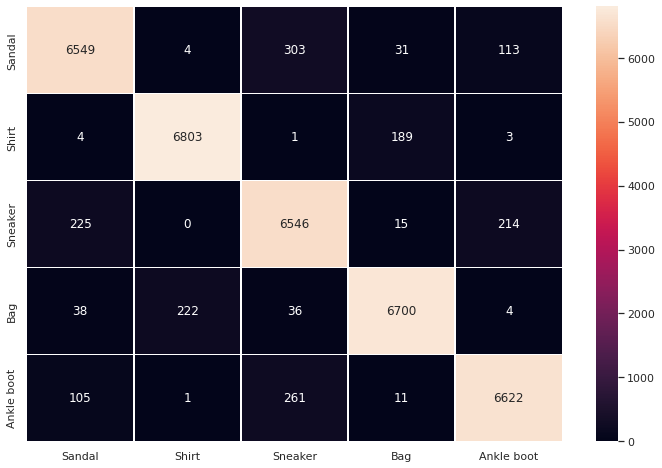

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(cm_lr_clf_reduced,
            fmt='.0f',
            annot=True,
            xticklabels=class_value_map.values(),
            yticklabels=class_value_map.values(),
            linewidths=.5)

Trzy powtórzenia treningu i testowania modelu w podstawowy sposób

In [ ]:
lr_clf_sklearn_f1score = []

Logistic regression sklearn score: 0.9442
Logistic regression f1 score weighted: 0.9442636161286296
-----------------------------------------------------
Logistic regression sklearn score: 0.9444
Logistic regression f1 score weighted: 0.9444598526161159
-----------------------------------------------------
Logistic regression sklearn score: 0.9444
Logistic regression f1 score weighted: 0.9444598526161159
-----------------------------------------------------


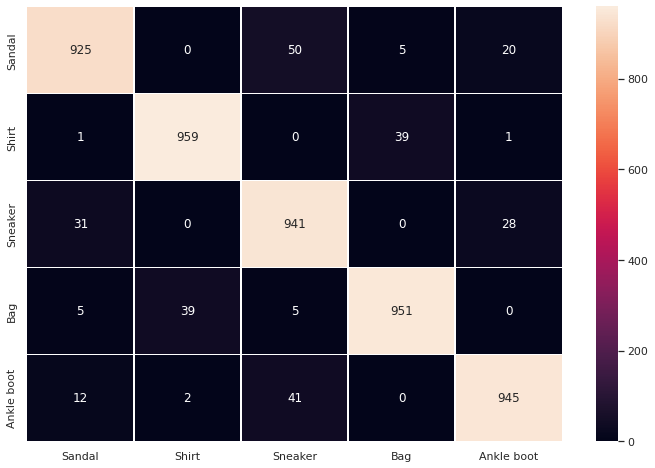

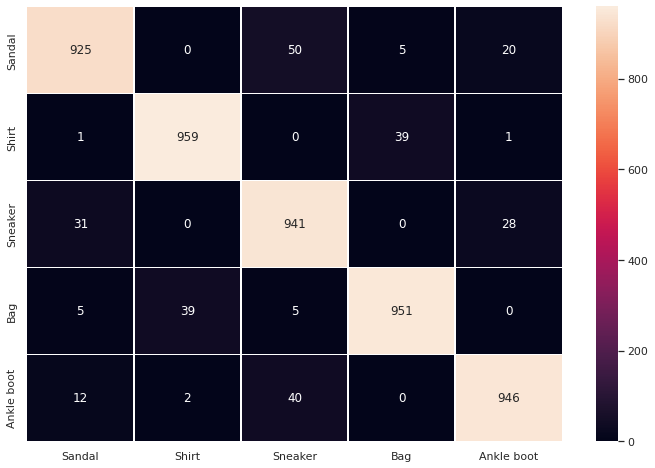

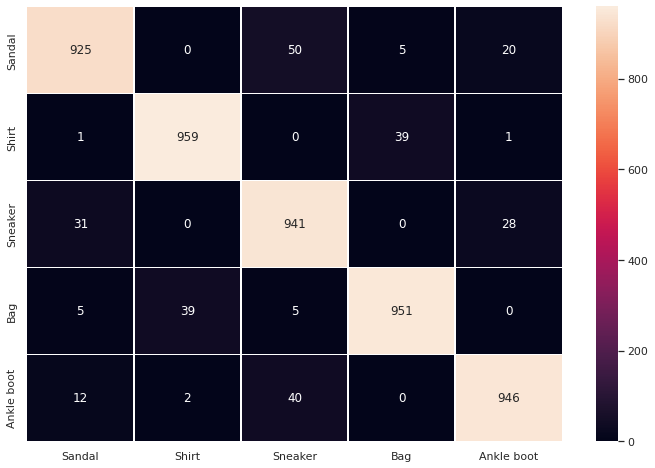

In [ ]:
for i in range(3):
  lr_clf = LogisticRegression(C=2,
                            random_state=i,
                            solver='saga',
                            penalty='l1',
                            multi_class='multinomial')

  lr_clf.fit(X_train, y_train)

  print("Logistic regression sklearn score:", lr_clf.score(X_test, y_test))

  y_pred_lr = lr_clf.predict(X_test)

  f1_score_lr_clf = f1_score(y_test, y_pred_lr, average='weighted')

  lr_clf_sklearn_f1score.append(f1_score_lr_clf)

  print("Logistic regression f1 score weighted:", f1_score_lr_clf)
  print("-----------------------------------------------------")

  cm_lr = confusion_matrix(y_test, y_pred_lr)

  figure(i)
  sns.set(rc={'figure.figsize':(12,8)})
  sns.heatmap(cm_lr,
              fmt='.0f',
              annot=True,
              xticklabels=class_value_map.values(),
              yticklabels=class_value_map.values(),
              linewidths=.5)

In [ ]:
print_metrics(np.array(lr_clf_sklearn_f1score))

---------------------------------------------------------------------------
Wyniki F1 weighted dla kolejnych modeli: [0.94426362 0.94445985 0.94445985]
Średnia wyników F1 weighted: 0.9443944404536205
Odchylenie standardowe wyników F1 weighted 9.250676734516359e-05
---------------------------------------------------------------------------


## Wersja II rozwiązania - zastosowanie MLP

### MLP z wykorzystaniem biblioteki sklearn

In [168]:
mlp_clf_sklearn_f1score = []

MLP sklearn score: 0.9694
MLP sklearn f1 score weighted: 0.9694150530981617
-----------------------------------------------------
MLP sklearn score: 0.9728
MLP sklearn f1 score weighted: 0.9728417656706723
-----------------------------------------------------
MLP sklearn score: 0.9736
MLP sklearn f1 score weighted: 0.9736008236665064
-----------------------------------------------------


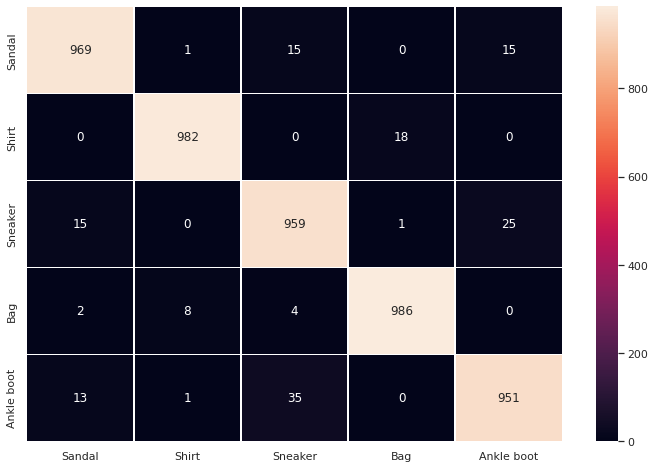

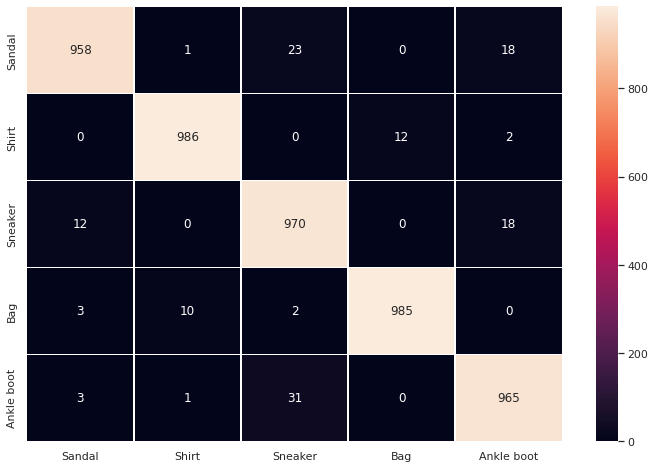

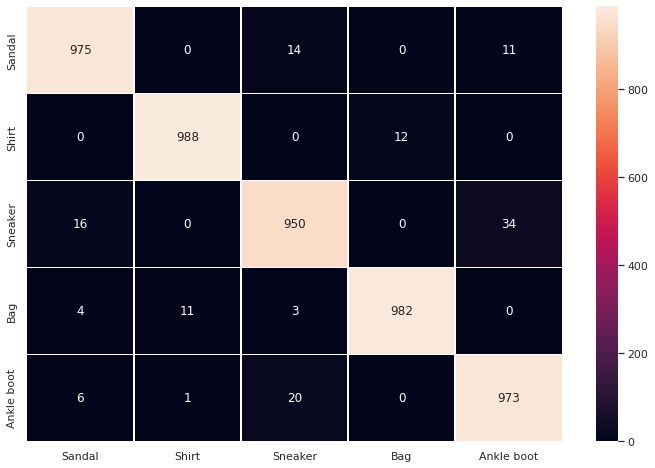

In [170]:
from sklearn.neural_network import MLPClassifier

for i in range(3):
  mlp_clf = MLPClassifier(random_state=i,
                          max_iter=500,
                          solver='adam',
                          activation='relu').fit(X_train, y_train)

  print("MLP sklearn score:", mlp_clf.score(X_test, y_test))

  y_pred_mlp = mlp_clf.predict(X_test)

  f1_score_mlp_sklearn = f1_score(y_test, y_pred_mlp, average='weighted')

  mlp_clf_sklearn_f1score.append(f1_score_mlp_sklearn)

  print("MLP sklearn f1 score weighted:", f1_score_mlp_sklearn)
  print("-----------------------------------------------------")

  cm_mlp = confusion_matrix(y_test, y_pred_mlp)

  figure(i)
  sns.set(rc={'figure.figsize':(12,8)})
  sns.heatmap(cm_mlp,
              fmt='.0f',
              annot=True,
              xticklabels=class_value_map.values(),
              yticklabels=class_value_map.values(),
              linewidths=.5)

In [171]:
print_metrics(np.array(mlp_clf_sklearn_f1score))

---------------------------------------------------------------------------
Wyniki F1 weighted dla kolejnych modeli: [0.96941505 0.97284177 0.97360082]
Średnia wyników F1 weighted: 0.9719525474784468
Odchylenie standardowe wyników F1 weighted 0.0018208423980388367
---------------------------------------------------------------------------


### MLP z wykorzystaniem Keras

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [176]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

train_data_mask = np.isin(y_train, class_values)
test_data_mask = np.isin(y_test, class_values)

X_train, y_train = X_train[train_data_mask], y_train[train_data_mask]
X_test, y_test = X_test[test_data_mask], y_test[test_data_mask]

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [183]:
mlp_keras_f1scores = []

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               200960    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dropout_14 (Dropout)        (None, 256)              

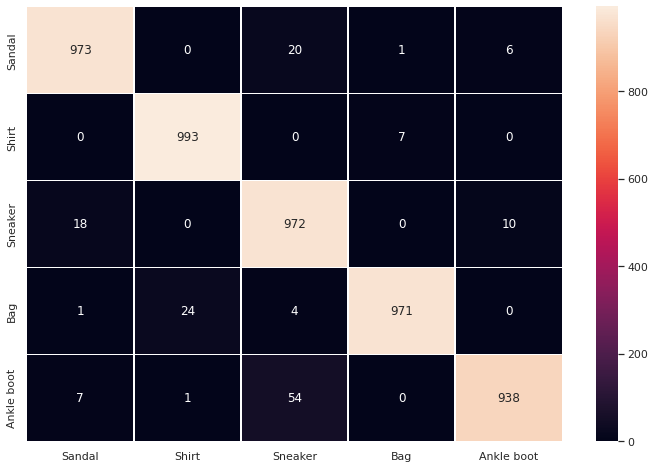

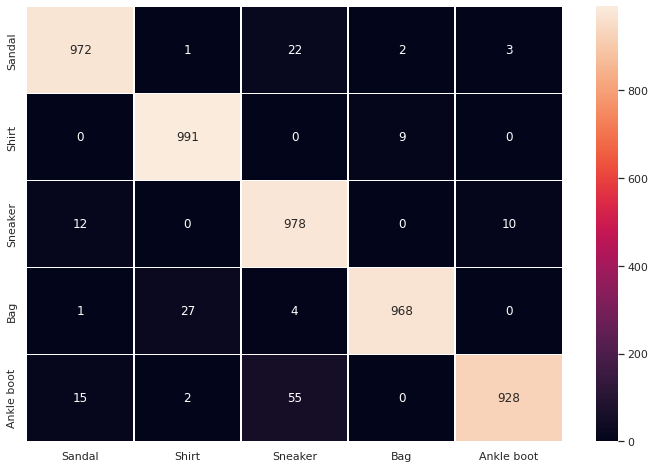

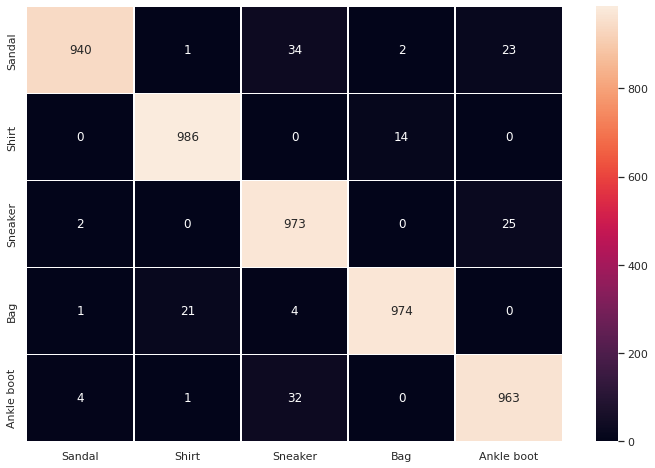

In [184]:
for i in range(3):
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.35))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.35))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.35))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  history = model.fit(
      X_train, 
      y_train,
      epochs=20,
      verbose=1,
      batch_size=32
  )

  y_test_pred = model.predict(X_test)

  y_test_pred = np.argmax(y_test_pred, axis=1)
  y_test_pred = y_test_pred.tolist()
  y_test_pred = to_categorical(y_test_pred, 10)

  mlp_keras_f1score = f1_score(y_test, y_test_pred, average='weighted')

  mlp_keras_f1scores.append(mlp_keras_f1score)

  pred_class_labels = np.argmax(y_test_pred, axis=1)
  class_labels =np.argmax(y_test, axis=1)

  figure(i)
  cm_mlp = confusion_matrix(class_labels, pred_class_labels)
  sns.set(rc={'figure.figsize':(12,8)})
  sns.heatmap(cm_mlp,
              fmt='.0f',
              annot=True,
              xticklabels=class_value_map.values(),
              yticklabels=class_value_map.values(),
              linewidths=.5)

In [185]:
print_metrics(np.array(mlp_keras_f1scores))

---------------------------------------------------------------------------
Wyniki F1 weighted dla kolejnych modeli: [0.96946154 0.96743167 0.96726374]
Średnia wyników F1 weighted: 0.968052317009279
Odchylenie standardowe wyników F1 weighted 0.0009988285370203644
---------------------------------------------------------------------------


## Obserwacje i podsumowanie wyników

Na podstawie macierzy pomyłek wyświetlanych dla każdego z klasyfikatorów, można zaobserwować, że dla danego zestawu danych - często mylone między sobą klasy to 'ankle boot', 'sneaker', 'sandal'.


|                    | F1 weighted - średnia | F1 weighted - odchylenie standardowe |
|--------------------|-----------------------|--------------------------------------|
| LogisticRegression | 0.949                 | 0.00099                              |
| MLP (sklearn)      | 0.972                 | 0.00182                              |
| MLP (keras)        | 0.968                 | 0.00099                              |
